get_pixels_hu


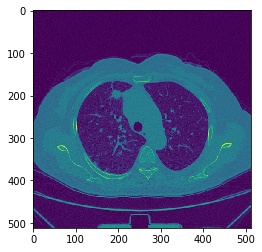

(158, 512, 512)
binarize_per_slice


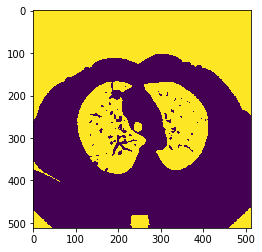

1


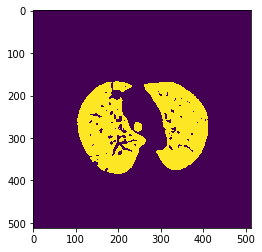

fill_hole


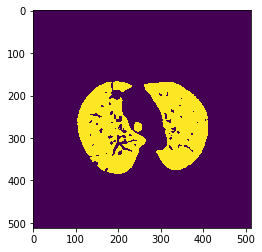

extract_main


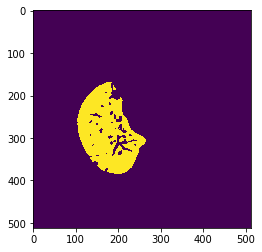

extract_main


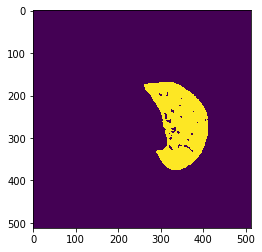

before fill_2d_hole


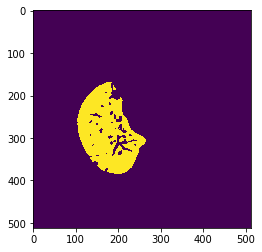

after fill_2d_hole


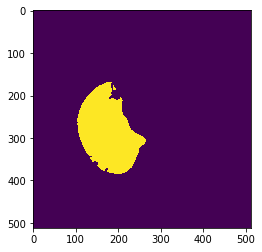

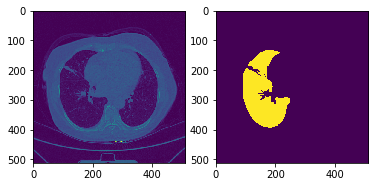

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology


ss = 120
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    if slices[0].ImagePositionPatient[2] == slices[1].ImagePositionPatient[2]:
        sec_num = 2;
        while slices[0].ImagePositionPatient[2] == slices[sec_num].ImagePositionPatient[2]:
            sec_num = sec_num+1;
        slice_num = int(len(slices) / sec_num)
        slices.sort(key = lambda x:float(x.InstanceNumber))
        slices = slices[0:slice_num]
        slices.sort(key = lambda x:float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    print 'get_pixels_hu'
    a = np.array(image, dtype=np.int16)
    plt.imshow(a[ss])
    plt.show()
    
    return np.array(image, dtype=np.int16), np.array([slices[0].SliceThickness] + slices[0].PixelSpacing, dtype=np.float32)

def binarize_per_slice(image, spacing, intensity_th=-600, sigma=1, area_th=30, eccen_th=0.99, bg_patch_size=10):
    bw = np.zeros(image.shape, dtype=bool)
    print image.shape
    
    # prepare a mask, with all corner values set to nan
    image_size = image.shape[1]
    grid_axis = np.linspace(-image_size/2+0.5, image_size/2-0.5, image_size)
    x, y = np.meshgrid(grid_axis, grid_axis)
    d = (x**2+y**2)**0.5
    nan_mask = (d<image_size/2).astype(float)
    nan_mask[nan_mask == 0] = np.nan
    for i in range(image.shape[0]):
        # Check if corner pixels are identical, if so the slice  before Gaussian filtering
        if len(np.unique(image[i, 0:bg_patch_size, 0:bg_patch_size])) == 1:
            current_bw = scipy.ndimage.filters.gaussian_filter(np.multiply(image[i].astype('float32'), nan_mask), sigma, truncate=2.0) < intensity_th
        else:
            current_bw = scipy.ndimage.filters.gaussian_filter(image[i].astype('float32'), sigma, truncate=2.0) < intensity_th
        
        # select proper components
        label = measure.label(current_bw)
        #print label.shape
        properties = measure.regionprops(label)
        valid_label = set()
        for prop in properties:
            if prop.area * spacing[1] * spacing[2] > area_th and prop.eccentricity < eccen_th:  #连通域的条件
                valid_label.add(prop.label)
        #print label
        current_bw = np.in1d(label, list(valid_label)).reshape(label.shape)  #子集判定
        bw[i] = current_bw
    print 'binarize_per_slice'
    plt.imshow(bw[ss])
    plt.show()
    return bw

def all_slice_analysis(bw, spacing, cut_num=0, vol_limit=[0.68, 8.2], area_th=6e3, dist_th=62):
    # in some cases, several top layers need to be removed first
    if cut_num > 0:
        bw0 = np.copy(bw)
        bw[-cut_num:] = False
    label = measure.label(bw, connectivity=1)
    # remove components access to corners
    mid = int(label.shape[2] / 2)
    bg_label = set([label[0, 0, 0], label[0, 0, -1], label[0, -1, 0], label[0, -1, -1], \
                    label[-1-cut_num, 0, 0], label[-1-cut_num, 0, -1], label[-1-cut_num, -1, 0], label[-1-cut_num, -1, -1], \
                    label[0, 0, mid], label[0, -1, mid], label[-1-cut_num, 0, mid], label[-1-cut_num, -1, mid]])
    for l in bg_label:
        label[label == l] = 0
        
    # select components based on volume
    properties = measure.regionprops(label)
    for prop in properties:
        if prop.area * spacing.prod() < vol_limit[0] * 1e6 or prop.area * spacing.prod() > vol_limit[1] * 1e6:
            label[label == prop.label] = 0
            
    # prepare a distance map for further analysis
    x_axis = np.linspace(-label.shape[1]/2+0.5, label.shape[1]/2-0.5, label.shape[1]) * spacing[1]
    y_axis = np.linspace(-label.shape[2]/2+0.5, label.shape[2]/2-0.5, label.shape[2]) * spacing[2]
    x, y = np.meshgrid(x_axis, y_axis)
    d = (x**2+y**2)**0.5
    vols = measure.regionprops(label)
    valid_label = set()
    # select components based on their area and distance to center axis on all slices
    for vol in vols:
        single_vol = label == vol.label
        slice_area = np.zeros(label.shape[0])
        min_distance = np.zeros(label.shape[0])
        for i in range(label.shape[0]):
            slice_area[i] = np.sum(single_vol[i]) * np.prod(spacing[1:3])
            min_distance[i] = np.min(single_vol[i] * d + (1 - single_vol[i]) * np.max(d))
        
        if np.average([min_distance[i] for i in range(label.shape[0]) if slice_area[i] > area_th]) < dist_th:
            valid_label.add(vol.label)
    #print label[label>10]      
    bw = np.in1d(label, list(valid_label)).reshape(label.shape)
    # fill back the parts removed earlier
    if cut_num > 0:
        # bw1 is bw with removed slices, bw2 is a dilated version of bw, part of their intersection is returned as final mask
        bw1 = np.copy(bw)
        bw1[-cut_num:] = bw0[-cut_num:]
        bw2 = np.copy(bw)
        bw2 = scipy.ndimage.binary_dilation(bw2, iterations=cut_num)
        bw3 = bw1 & bw2
        label = measure.label(bw, connectivity=1)
        label3 = measure.label(bw3, connectivity=1)
        l_list = list(set(np.unique(label)) - {0})
        valid_l3 = set()
        for l in l_list:
            indices = np.nonzero(label==l)
            l3 = label3[indices[0][0], indices[1][0], indices[2][0]]
            if l3 > 0:
                valid_l3.add(l3)
        bw = np.in1d(label3, list(valid_l3)).reshape(label3.shape)
    print len(valid_label)
    plt.imshow(bw[ss])
    plt.show()
    return bw, len(valid_label)

def fill_hole(bw):
    # fill 3d holes
    label = measure.label(~bw)
    # idendify corner components
    bg_label = set([label[0, 0, 0], label[0, 0, -1], label[0, -1, 0], label[0, -1, -1], \
                    label[-1, 0, 0], label[-1, 0, -1], label[-1, -1, 0], label[-1, -1, -1]])
    bw = ~np.in1d(label, list(bg_label)).reshape(label.shape)
    print 'fill_hole'
    plt.imshow(bw[ss])
    plt.show()
    return bw




def two_lung_only(bw, spacing, max_iter=22, max_ratio=4.8):    
    def extract_main(bw, cover=0.95):
        for i in range(bw.shape[0]):
            current_slice = bw[i]
            label = measure.label(current_slice)
            properties = measure.regionprops(label)
            properties.sort(key=lambda x: x.area, reverse=True)
            area = [prop.area for prop in properties]
            count = 0
            sum = 0
            while sum < np.sum(area)*cover:
                sum = sum+area[count]
                count = count+1
            filter = np.zeros(current_slice.shape, dtype=bool)
            for j in range(count):
                bb = properties[j].bbox
                filter[bb[0]:bb[2], bb[1]:bb[3]] = filter[bb[0]:bb[2], bb[1]:bb[3]] | properties[j].convex_image
            bw[i] = bw[i] & filter
           
        label = measure.label(bw)
        properties = measure.regionprops(label)
        properties.sort(key=lambda x: x.area, reverse=True)
        bw = label==properties[0].label
        print 'extract_main'
        plt.imshow(bw[ss])
        plt.show()

        return bw
    
    def fill_2d_hole(bw):
        for i in range(bw.shape[0]):
            current_slice = bw[i]
            label = measure.label(current_slice)
            properties = measure.regionprops(label)
            for prop in properties:
                bb = prop.bbox
                current_slice[bb[0]:bb[2], bb[1]:bb[3]] = current_slice[bb[0]:bb[2], bb[1]:bb[3]] | prop.filled_image
            bw[i] = current_slice
        return bw
    
    found_flag = False
    iter_count = 0
    bw0 = np.copy(bw)
    while not found_flag and iter_count < max_iter:
        label = measure.label(bw, connectivity=2)
        properties = measure.regionprops(label)
        properties.sort(key=lambda x: x.area, reverse=True)
        if len(properties) > 1 and properties[0].area/properties[1].area < max_ratio:
            found_flag = True
            bw1 = label == properties[0].label
            bw2 = label == properties[1].label
        else:
            bw = scipy.ndimage.binary_erosion(bw)
            iter_count = iter_count + 1
    
    if found_flag:
        d1 = scipy.ndimage.morphology.distance_transform_edt(bw1 == False, sampling=spacing)
        d2 = scipy.ndimage.morphology.distance_transform_edt(bw2 == False, sampling=spacing)
        bw1 = bw0 & (d1 < d2)
        bw2 = bw0 & (d1 > d2)
                
        bw1 = extract_main(bw1)
        bw2 = extract_main(bw2)
        
    else:
        bw1 = bw0
        bw2 = np.zeros(bw.shape).astype('bool')
    
    print 'before fill_2d_hole'
    plt.imshow(bw1[ss])
    plt.show()    
    bw1 = fill_2d_hole(bw1)
    print 'after fill_2d_hole'
    plt.imshow(bw1[ss])
    plt.show()    
    bw2 = fill_2d_hole(bw2)
    bw = bw1 | bw2

    return bw1, bw2, bw

def step1_python(case_path):
    case = load_scan(case_path)
    case_pixels, spacing = get_pixels_hu(case)
    bw = binarize_per_slice(case_pixels, spacing)
    flag = 0
    cut_num = 0
    cut_step = 2
    bw0 = np.copy(bw)
    while flag == 0 and cut_num < bw.shape[0]:
        bw = np.copy(bw0)
        bw, flag = all_slice_analysis(bw, spacing, cut_num=cut_num, vol_limit=[0.68,7.5])
        cut_num = cut_num + cut_step
    
    bw = fill_hole(bw) 
    #print bw
    bw1, bw2, bw = two_lung_only(bw, spacing)
    return case_pixels, bw1, bw2, spacing
    

INPUT_FOLDER = '/home/liujing/Documents/lung_nodule_detection/data/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
case_pixels, m1, m2, spacing = step1_python(os.path.join(INPUT_FOLDER,patients[3]))
plt.figure()
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
plt.sca(ax1)
plt.imshow(case_pixels[80])
plt.sca(ax2)
plt.imshow((m1)[80])
plt.show()
#     first_patient = load_scan(INPUT_FOLDER + patients[25])
#     first_patient_pixels, spacing = get_pixels_hu(first_patient)
#     plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
#     plt.xlabel("Hounsfield Units (HU)")
#     plt.ylabel("Frequency")
#     plt.show()
    
#     # Show some slice in the middle
#     h = 80
#     plt.imshow(first_patient_pixels[h], cmap=plt.cm.gray)
#     plt.show()
    
#     bw = binarize_per_slice(first_patient_pixels, spacing)
#     plt.imshow(bw[h], cmap=plt.cm.gray)
#     plt.show()
    
#     flag = 0
#     cut_num = 0
#     while flag == 0:
#         bw, flag = all_slice_analysis(bw, spacing, cut_num=cut_num)
#         cut_num = cut_num + 1
#     plt.imshow(bw[h], cmap=plt.cm.gray)
#     plt.show()
    
#     bw = fill_hole(bw)
#     plt.imshow(bw[h], cmap=plt.cm.gray)
#     plt.show()
    
#     bw1, bw2, bw = two_lung_only(bw, spacing)
#     plt.imshow(bw[h], cmap=plt.cm.gray)
#     plt.show()


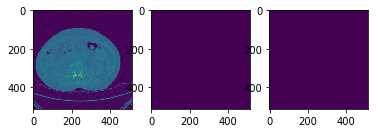

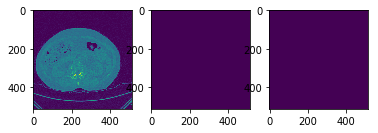

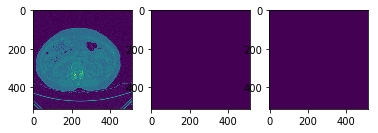

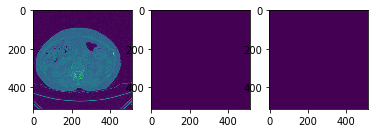

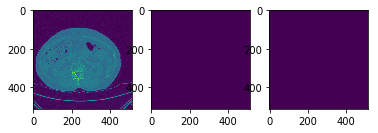

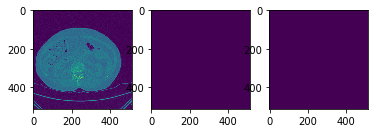

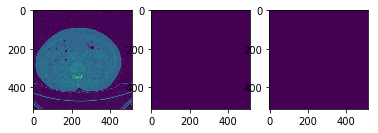

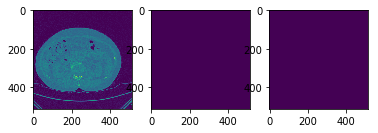

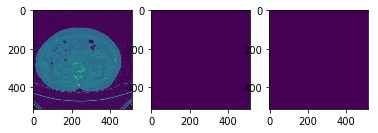

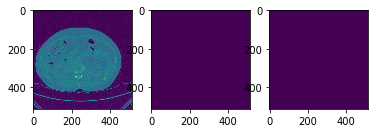

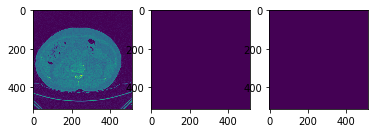

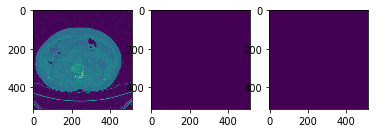

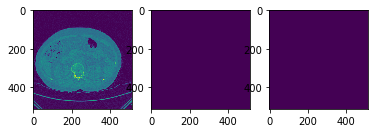

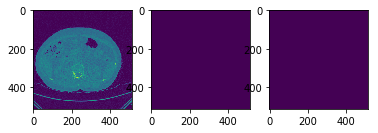

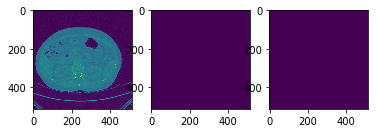

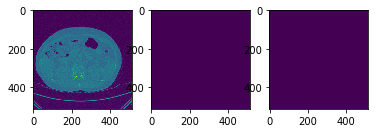

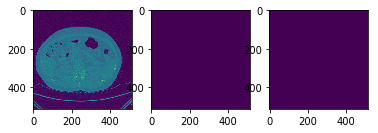

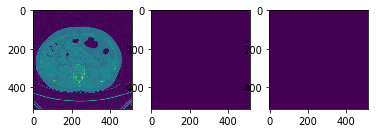

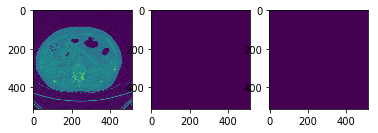

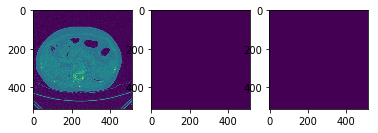

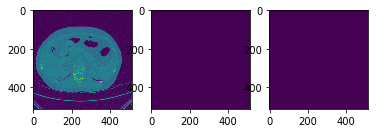

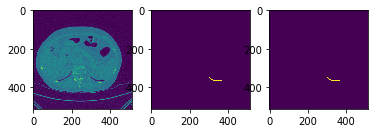

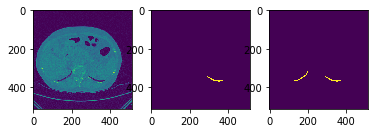

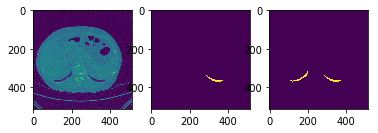

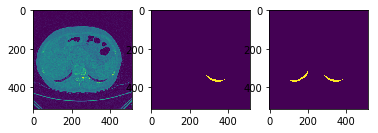

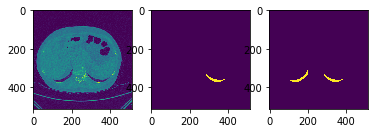

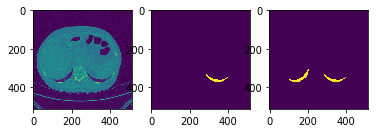

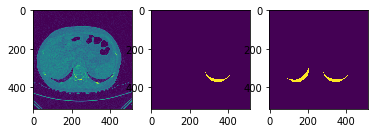

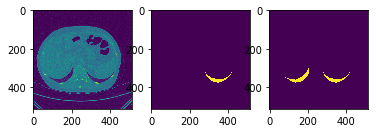

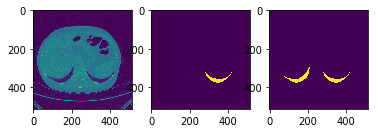

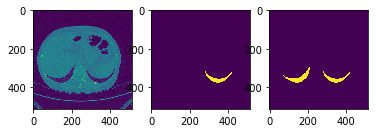

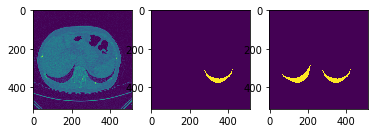

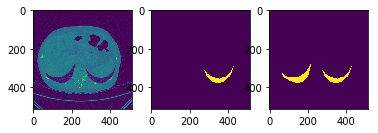

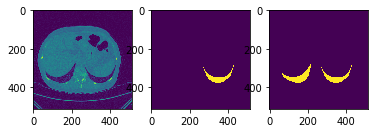

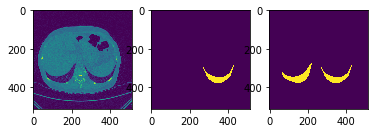

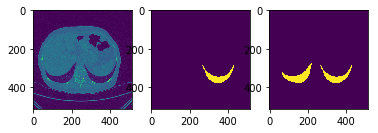

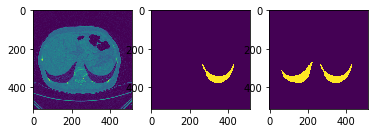

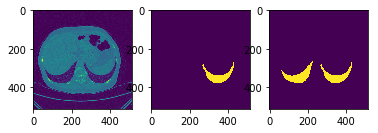

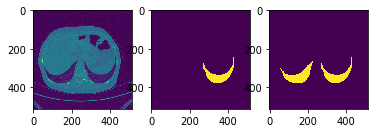

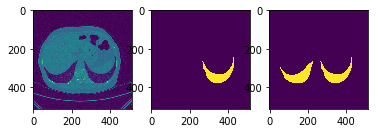

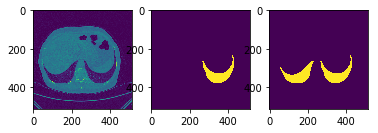

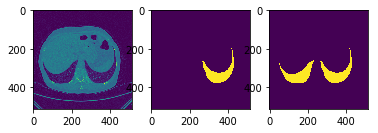

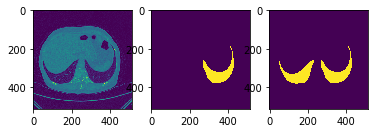

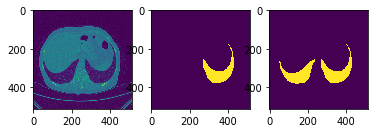

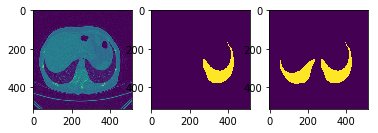

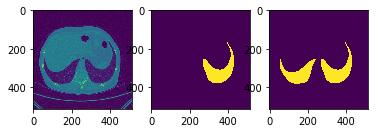

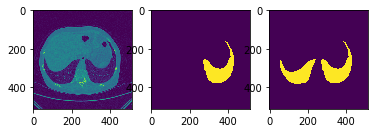

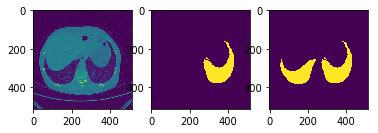

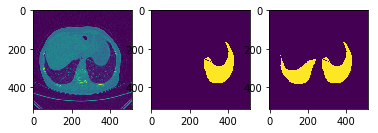

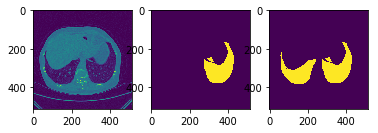

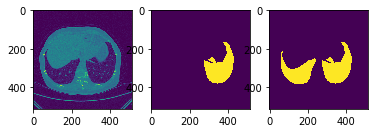

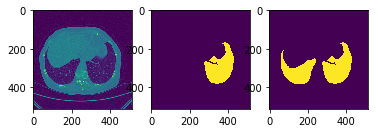

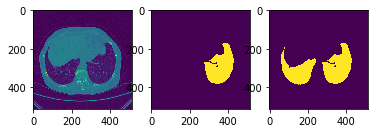

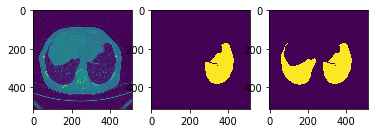

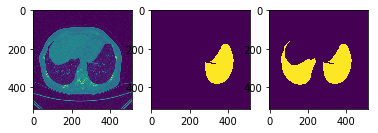

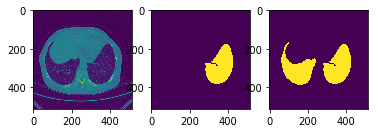

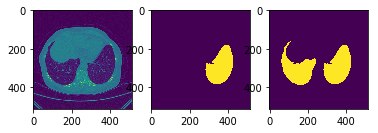

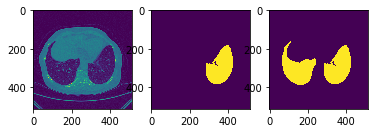

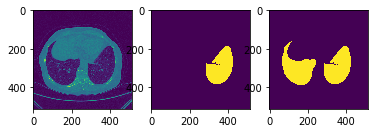

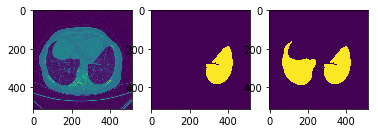

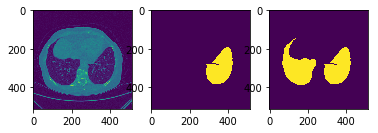

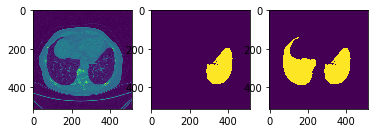

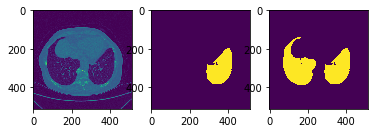

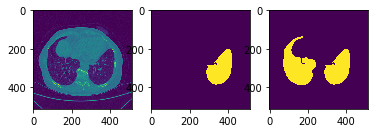

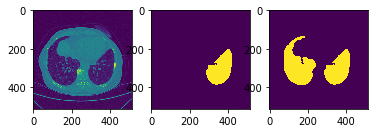

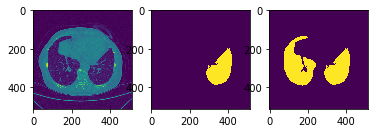

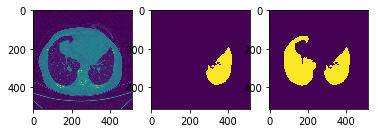

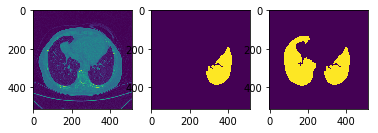

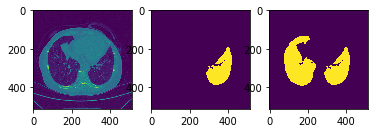

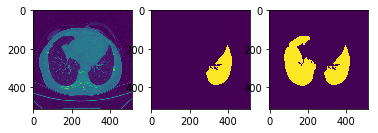

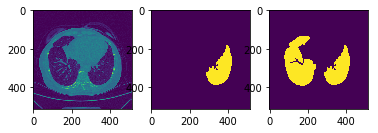

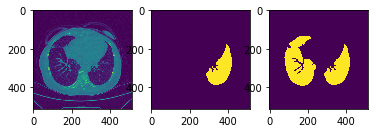

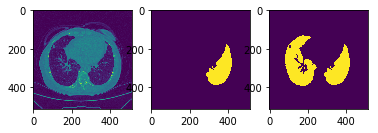

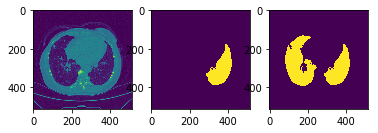

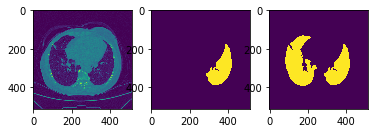

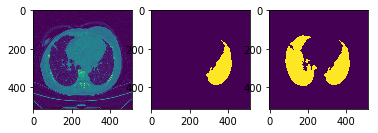

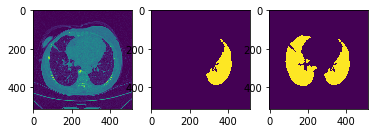

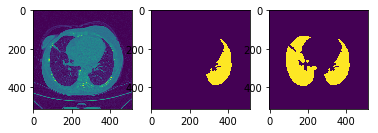

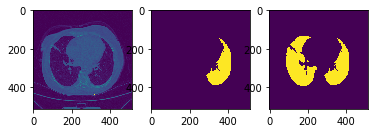

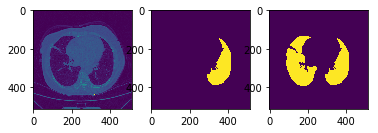

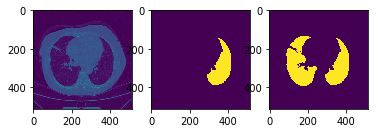

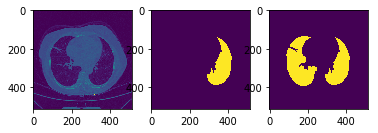

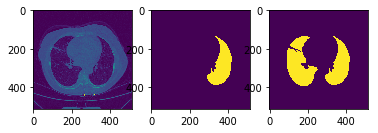

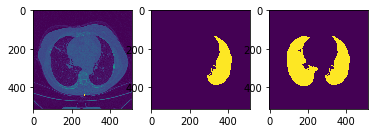

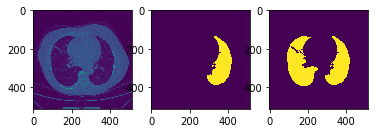

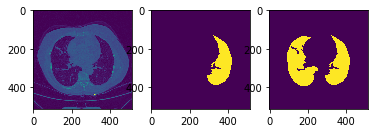

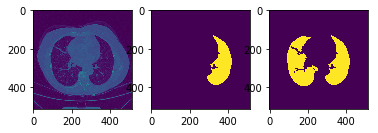

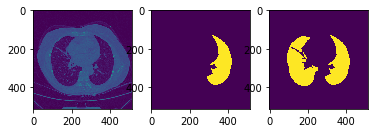

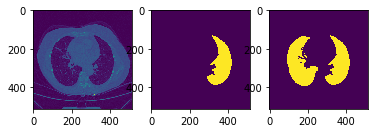

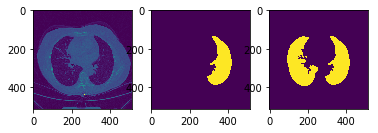

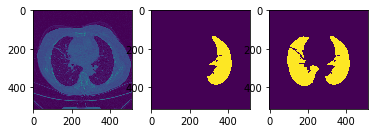

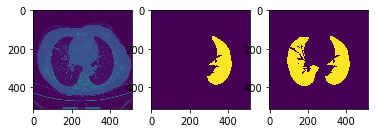

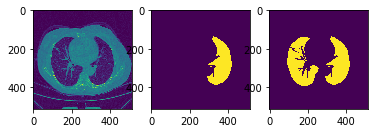

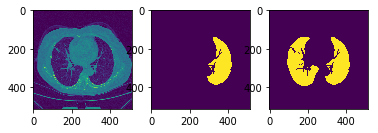

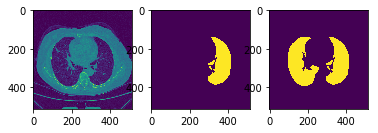

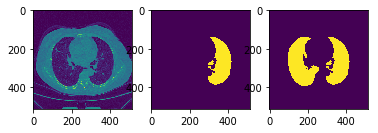

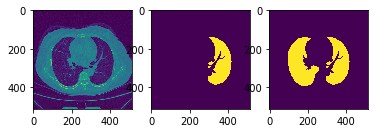

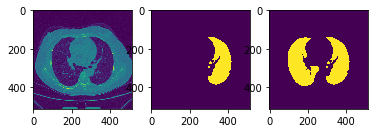

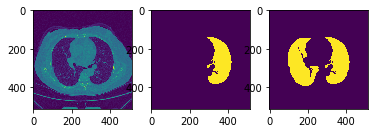

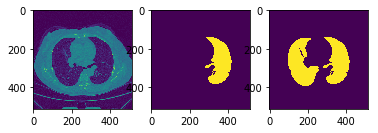

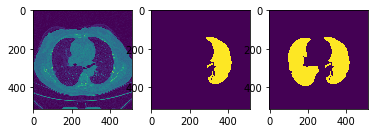

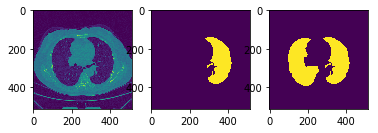

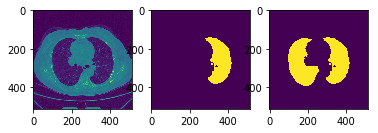

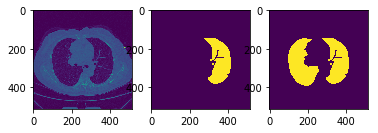

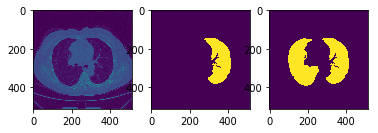

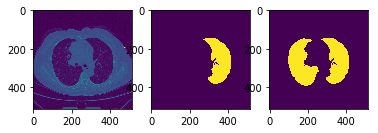

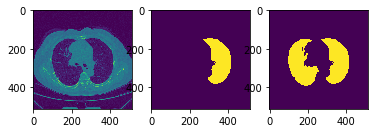

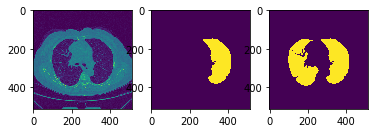

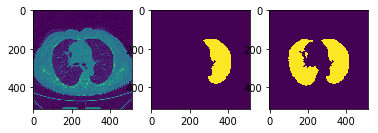

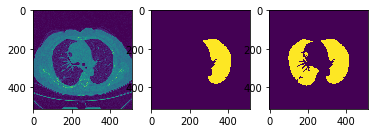

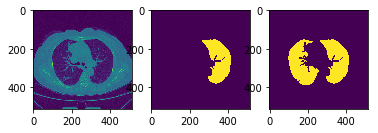

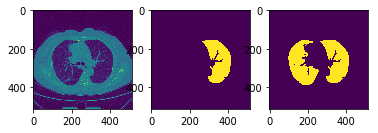

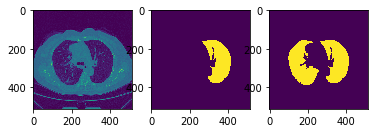

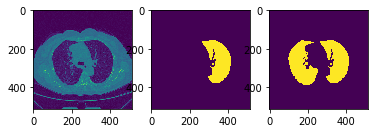

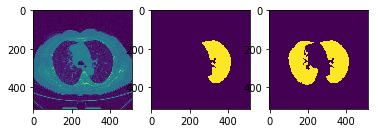

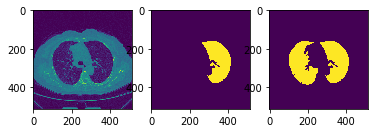

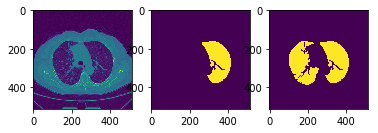

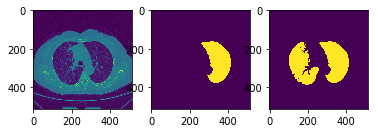

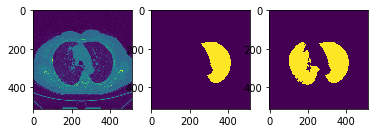

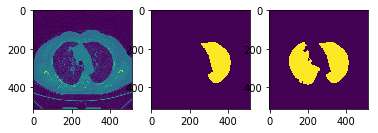

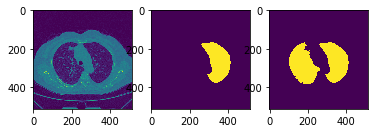

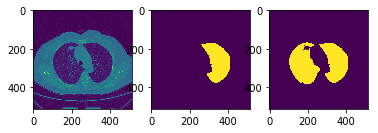

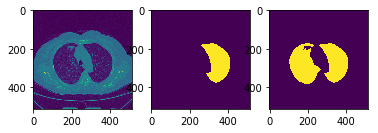

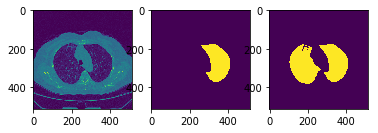

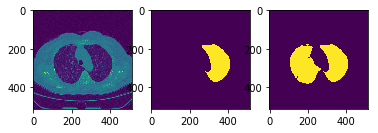

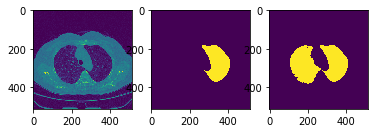

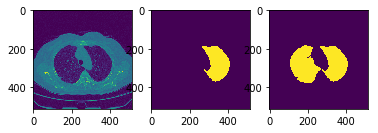

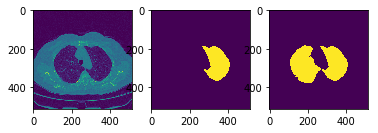

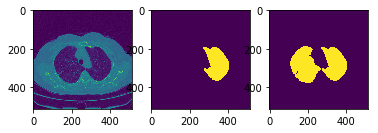

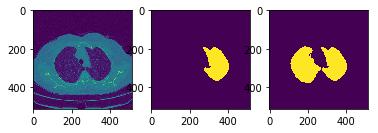

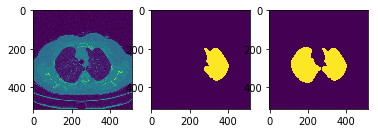

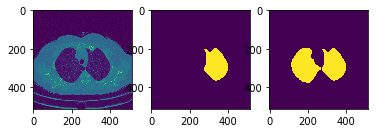

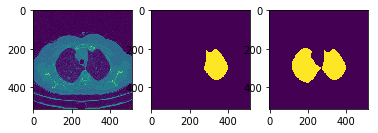

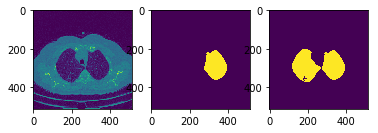

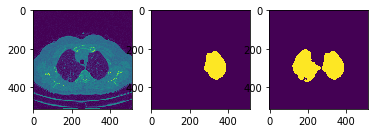

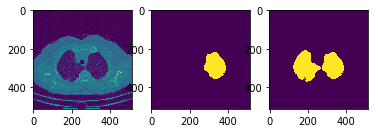

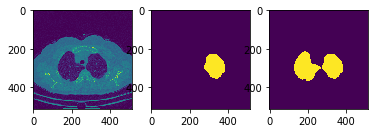

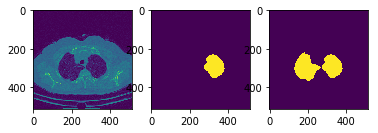

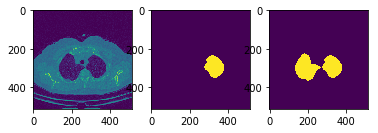

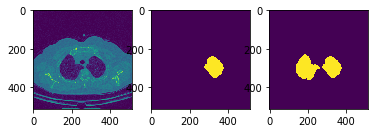

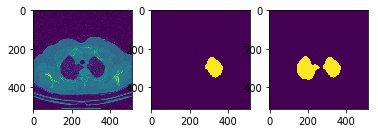

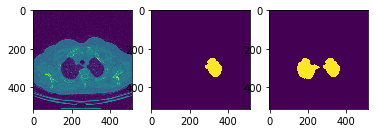

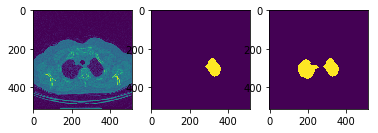

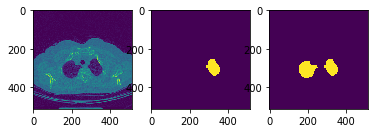

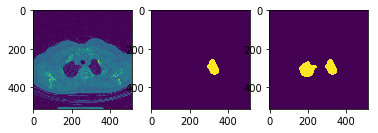

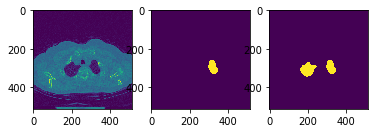

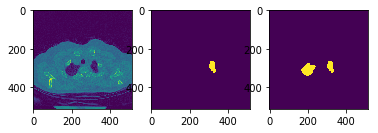

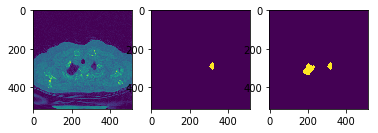

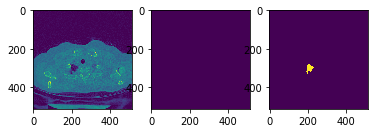

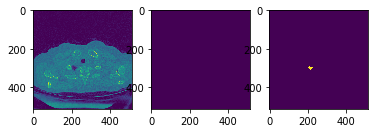

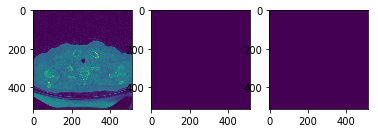

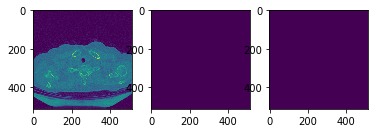

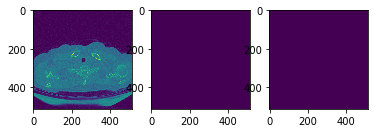

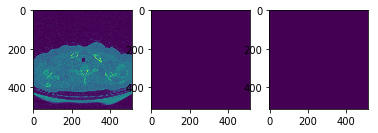

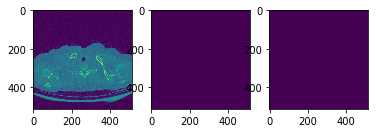

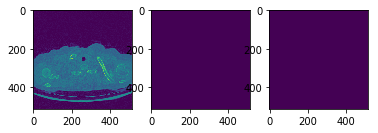

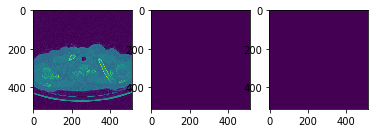

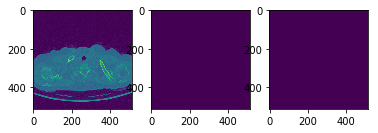

IndexError: index 158 is out of bounds for axis 0 with size 158

In [2]:
m = 173
for i in range(m):
    plt.figure()
    ax1 = plt.subplot(1,3,1)
    ax2 = plt.subplot(1,3,2)
    ax3 = plt.subplot(1,3,3)
    plt.sca(ax1)
    plt.imshow(case_pixels[i])
    plt.sca(ax2)
    plt.imshow((m2)[i])
    plt.sca(ax3)
    plt.imshow((m2+m1)[i])
    plt.show()

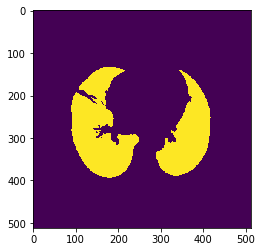

In [4]:
plt.figure()
plt.imshow((m1+m2)[80])
plt.show()

In [5]:
m1.shape

(158, 512, 512)

In [6]:
m2.shape

(158, 512, 512)

In [7]:
m1+m2

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, 

In [8]:
patients

['06ea1ff317a8652bb74f6710efa3b758be96524e',
 '6e0d4bef9a6a3c88d1c24cbb4e64d26526ad7cb1',
 '8a5a850d1f90a3b5e4cb6a3a137ac6be0c6768d9',
 '8b9a2378b94d14526f266148c7991e78f20fd1f4',
 'bfbfc66912c4a6a71ce8a4179e74af957abd2fe6 ',
 'c5aeb59f-9b52b436-4c12187a-fd90406d-fb55cc4b',
 'ce1ff1a4-180d882f-5401a107-db5428b4-f58b0322',
 'ded4983b-85e8b6b0-9b9c0898-232b7d47-c2122a5d']

In [9]:
Mask = m1+m2

In [10]:
Mask.shape

(158, 512, 512)

In [11]:
resolution = np.array([1,1,1])
newshape = np.round(np.array(Mask.shape)*spacing/resolution)

In [12]:
newshape

array([ 316.,  339.,  339.])

In [13]:
spacing

array([ 2.        ,  0.66210938,  0.66210938], dtype=float32)

In [14]:
xx,yy,zz= np.where(Mask)

In [15]:
xx.shape

(3860531,)

In [16]:
xx

array([ 21,  21,  21, ..., 149, 149, 149])

In [17]:
box = np.array([[np.min(xx),np.max(xx)],[np.min(yy),np.max(yy)],[np.min(zz),np.max(zz)]])

In [18]:
box

array([[ 21, 149],
       [130, 394],
       [ 54, 430]])

In [19]:
box = box*np.expand_dims(spacing,1)/np.expand_dims(resolution,1)

In [20]:
box

array([[  42.        ,  298.        ],
       [  86.07421875,  260.87109375],
       [  35.75390625,  284.70703125]])

In [21]:
np.expand_dims(spacing,1)

array([[ 2.        ],
       [ 0.66210938],
       [ 0.66210938]], dtype=float32)

In [23]:
box = np.floor(box).astype('int')
box

array([[ 42, 298],
       [ 86, 260],
       [ 35, 284]])

In [26]:
margin = 5
extendbox = np.vstack([np.max([[0,0,0],box[:,0]-margin],0),np.min([newshape,box[:,1]+2*margin],axis=0).T]).T
extendbox = extendbox.astype('int')

In [27]:
extendbox

array([[ 37, 308],
       [ 81, 270],
       [ 30, 294]])

In [28]:
convex_mask = m1

In [33]:
from skimage.morphology import convex_hull_image
from scipy.ndimage.morphology import binary_dilation,generate_binary_structure
def process_mask(mask):
    convex_mask = np.copy(mask)
    for i_layer in range(convex_mask.shape[0]):
        mask1  = np.ascontiguousarray(mask[i_layer])
        if np.sum(mask1)>0:
            mask2 = convex_hull_image(mask1)
            if np.sum(mask2)>2*np.sum(mask1):
                mask2 = mask1
        else:
            mask2 = mask1
        convex_mask[i_layer] = mask2
    struct = generate_binary_structure(3,1)  
    dilatedMask = binary_dilation(convex_mask,structure=struct,iterations=10) 
    return dilatedMask


In [34]:
dm1 = process_mask(m1)

In [35]:
dm1.shape

(158, 512, 512)

In [36]:
dm2 = process_mask(m2)

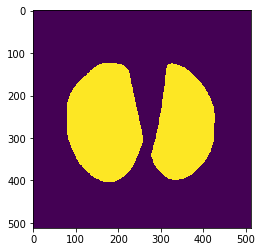

In [37]:
plt.figure()
plt.imshow((dm1+dm2)[80])
plt.show()

In [39]:
dilatedMask = dm1+dm2
Mask = m1+m2
extramask = dilatedMask ^ Mask

In [40]:
extramask.shape

(158, 512, 512)

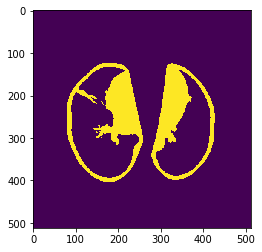

In [41]:
plt.figure()
plt.imshow(extramask[80])
plt.show()

In [44]:
bone_thresh = 210
pad_value = 170
im = case_pixels
im[np.isnan(im)]=-2000

In [45]:
def lumTrans(img):
    lungwin = np.array([-1200.,600.])
    newimg = (img-lungwin[0])/(lungwin[1]-lungwin[0])
    newimg[newimg<0]=0
    newimg[newimg>1]=1
    newimg = (newimg*255).astype('uint8')
    return newimg

In [46]:
sliceim = lumTrans(im)

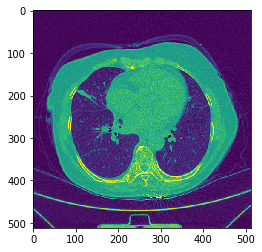

In [50]:
plt.figure()
plt.imshow(sliceim[80])
plt.show()

In [52]:
sliceim[80]

array([[28, 32, 31, ..., 28, 24, 28],
       [26, 26, 35, ..., 24, 34, 35],
       [28, 24, 30, ..., 28, 38, 28],
       ..., 
       [29, 30, 29, ..., 24, 24, 24],
       [28, 26, 33, ..., 37, 25, 24],
       [29, 27, 26, ..., 24, 28, 28]], dtype=uint8)

In [53]:
sliceim = sliceim*dilatedMask+pad_value*(1-dilatedMask).astype('uint8')

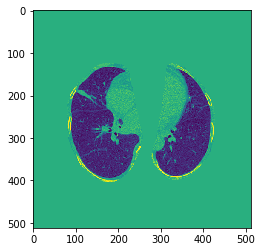

In [54]:
plt.figure()
plt.imshow(sliceim[80])
plt.show()

In [55]:
bones = sliceim*extramask>bone_thresh

In [58]:
bones.shape

(158, 512, 512)

In [59]:
sliceim[bones] = pad_value

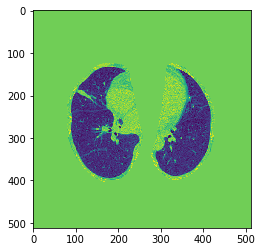

In [60]:
plt.figure()
plt.imshow(sliceim[80])
plt.show()

In [63]:
import warnings
from scipy.ndimage.interpolation import zoom

def resample(imgs, spacing, new_spacing,order = 2):
    if len(imgs.shape)==3:
        new_shape = np.round(imgs.shape * spacing / new_spacing)
        true_spacing = spacing * imgs.shape / new_shape
        resize_factor = new_shape / imgs.shape
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            imgs = zoom(imgs, resize_factor, mode = 'nearest',order=order)
        return imgs, true_spacing
    elif len(imgs.shape)==4:
        n = imgs.shape[-1]
        newimg = []
        for i in range(n):
            slice = imgs[:,:,:,i]
            newslice,true_spacing = resample(slice,spacing,new_spacing)
            newimg.append(newslice)
        newimg=np.transpose(np.array(newimg),[1,2,3,0])
        return newimg,true_spacing
    else:
        raise ValueError('wrong shape')
sliceim1,_ = resample(sliceim,spacing,resolution,order=1)

In [64]:
sliceim1.shape

(316, 339, 339)

In [65]:
sliceim2 = sliceim1[extendbox[0,0]:extendbox[0,1],
                    extendbox[1,0]:extendbox[1,1],
                    extendbox[2,0]:extendbox[2,1]]

In [66]:
sliceim2.shape

(271, 189, 264)

In [67]:
sliceim = sliceim2[np.newaxis,...]

In [68]:
sliceim.shape

(1, 271, 189, 264)

In [69]:
extendbox

array([[ 37, 308],
       [ 81, 270],
       [ 30, 294]])

In [70]:
extendbox[0,0]

37

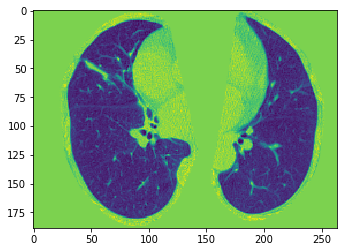

In [72]:
plt.figure()
plt.imshow(sliceim[0][130])
plt.show()